# 1. Chuẩn bị dữ liệu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import OneClassSVM
from sklearn.impute import KNNImputer

Mô tả các features:

ID: Mã số định danh của khách hàng.\
Warehouse block: Kho chứa hàng của công ty vận chuyển, được chia theo kho A, B, C, D, F.\
Mode of shipment: Cách thức chuyển phát Ship, Flight and Road.\
Customer care calls: Số lượng cuộc gọi hối giao hàng.\
Customer rating: Thang đánh giá bởi khách hàng, 1 (rất không hài lòng) - 5 (rất hài lòng).\
Cost of the product: Giá (đơn vị tính: USD).\
Prior purchases: Số lần khách hàng đã nhờ vận chuyển trước đây.\
Product importance: Mức độ quan trọng của hàng hóa low, medium, high.\
Gender: Giới tính (M/F).\
Discount offered: Số tiền giảm giá cho hàng hóa.\
Weight in gms: Số kí của hàng hóa (đơn vị tính: gram).\
Reached on time (target): 0-giao đúng hẹn, 1-giao trễ hẹn.

In [2]:
df = pd.read_csv("C:/Users/VivoBook/Downloads/ecom_ship.csv")
pd.set_option('display.max_columns', None)
df.head()


,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
# kích thước dataset
print('Before checking duplicated data:', df.shape)

df = df.drop_duplicates(keep='last')
print('After checking duplicated data:', df.shape)


Before checking duplicated data: (10999, 12)
After checking duplicated data: (10999, 12)


In [4]:
# kiểm tra missing value
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [5]:
# xóa cột không cần thiết
del df['ID']

# ép kiểu biến target về object
df[['Reached.on.Time_Y.N', 'Customer_rating']] = df[['Reached.on.Time_Y.N', 'Customer_rating']].astype('object')

# chuyển đổi đơn vị tính (g -> kg)
df['Weight_in_kg'] = df['Weight_in_gms'].apply(lambda x: x / 1000)
del df['Weight_in_gms']
df.insert(9, 'Weight_in_kg', df.pop('Weight_in_kg'))

df.head(5)

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_kg,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1.233,1
1,F,Flight,4,5,216,2,low,M,59,3.088,1
2,A,Flight,2,2,183,4,low,M,48,3.374,1
3,B,Flight,3,3,176,4,medium,M,10,1.177,1
4,C,Flight,2,2,184,3,medium,F,46,2.484,1


# 2. Biến định lượng

In [6]:
# thống kế mô tả cho biến định lượng
df.describe(include=['int64', 'float64'])

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_kg
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,210.196836,3.567597,13.373216,3.634017
std,1.141490,48.063272,1.522860,16.205527,1.635377
min,2.000000,96.000000,2.000000,1.000000,1.001000
25%,3.000000,169.000000,3.000000,4.000000,1.839500
50%,4.000000,214.000000,3.000000,7.000000,4.149000
75%,5.000000,251.000000,4.000000,10.000000,5.050000
max,7.000000,310.000000,10.000000,65.000000,7.846000


In [7]:
df_quatitative = df[df.describe(include=['int64', 'float64']).columns]
df_quatitative.head(3)

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_kg
0,4,177,3,44,1.233
1,4,216,2,59,3.088
2,2,183,4,48,3.374


# 3. Tiền xử lí biến định tính

In [8]:
# thống kế mô tả cho biến định tính
df.describe(include='object')


,Warehouse_block,Mode_of_Shipment,Customer_rating,Product_importance,Gender,Reached.on.Time_Y.N
count,10999,10999,10999,10999,10999,10999
unique,5,3,5,3,2,2
top,F,Ship,3,low,F,1
freq,3666,7462,2239,5297,5545,6563


In [9]:
df_qualitative = df[df.describe(include=['object']).columns]
df_qualitative.head(3)


,Warehouse_block,Mode_of_Shipment,Customer_rating,Product_importance,Gender,Reached.on.Time_Y.N
0,D,Flight,2,low,F,1
1,F,Flight,5,low,M,1
2,A,Flight,2,low,M,1


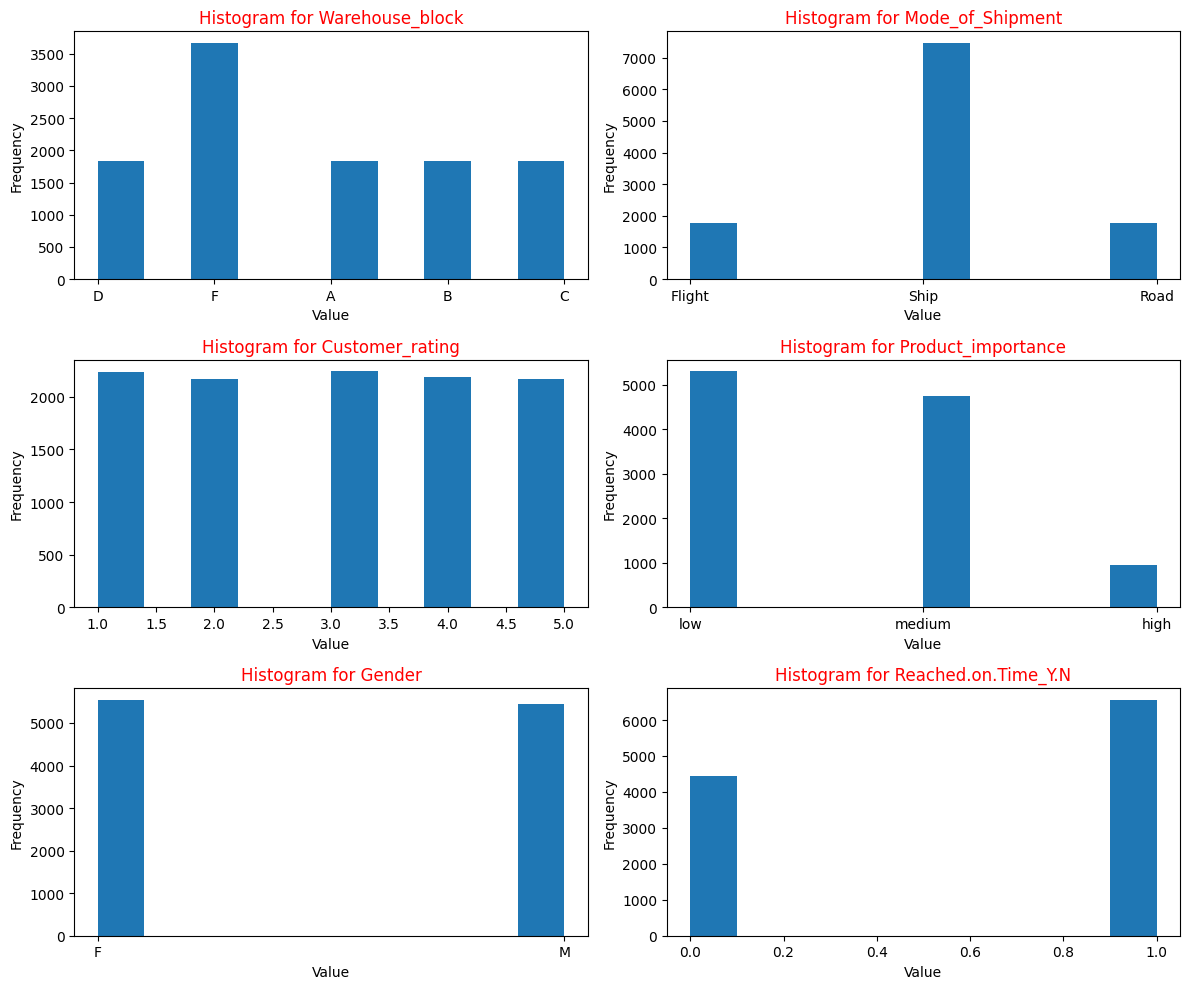

In [10]:
def draw_histogram(dataset, col_name, ax):
    ax.hist(dataset[col_name])
    ax.set_title(f'Histogram for {col_name}', color='r')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

fig, axes = plt.subplots(3, 2, figsize=(12, 10)) # Tạo ma trận 3 hàng và 2 cột
axes = axes.flatten()                            # Làm phẳng mảng axes nếu nó có nhiều hàng và cột

# Duyệt qua từng cột và vẽ biểu đồ
for i, col in enumerate(df_qualitative.columns):
    draw_histogram(df_qualitative, col, axes[i])

plt.tight_layout()  # Điều chỉnh các biểu đồ sao cho không bị chồng lên nhau
plt.show()


In [11]:
# Cách 1: Lập trình thông thường

# Bước 1: Chuyển đổi các biến định tính thành dạng số (One-Hot Encoding)
encoder = OneHotEncoder(drop='first')  # 'drop' để tránh đa cộng tuyến (collinearity)
df_encoded = encoder.fit_transform(df_qualitative).toarray()
df_encoded

# Bước 2: Sử dụng OCSVM để phát hiện outliers
ocsvm = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')  # nu: tỷ lệ outliers dự đoán
ocsvm.fit(df_encoded)

# Dự đoán: -1 là outlier, 1 là normal
predictions = ocsvm.predict(df_encoded)
outlier_indexes = df.index[predictions == -1].tolist()
print("Predictions (1 = Normal, -1 = Outlier):", predictions, '\n')

# Chỉ thể hiện các outliers
outliers = df_qualitative[predictions == -1]
outliers


Predictions (1 = Normal, -1 = Outlier): [-1 -1  1 ... -1  1  1] 



,Warehouse_block,Mode_of_Shipment,Customer_rating,Product_importance,Gender,Reached.on.Time_Y.N
0,D,Flight,2,low,F,1
1,F,Flight,5,low,M,1
4,C,Flight,2,medium,F,1
11,F,Flight,5,medium,F,1
13,F,Flight,4,high,M,1
...,...,...,...,...,...,...
10979,F,Ship,2,low,F,1
10981,F,Ship,2,low,M,0
10983,B,Ship,3,medium,M,1
10990,C,Ship,4,low,M,0


In [12]:
# Cách 2: Lập trình hàm

# Bước 1: Chuyển đổi các biến định tính thành dạng số (One-Hot Encoding)
one_hot_encode = lambda df_qualitative: OneHotEncoder(drop='first').fit_transform(df_qualitative).toarray()

# Bước 2: Sử dụng OCSVM để phát hiện outliers
detect_outliers = lambda df_encoded, nu=0.1, kernel='rbf', gamma='scale': OneClassSVM(nu=nu, kernel=kernel, gamma=gamma).fit(df_encoded).predict(df_encoded)

# Bước 3: Trích xuất outliers
get_outliers = lambda df_qualitative, predictions: df_qualitative[predictions == -1]

def main(df_qualitative):
    df_encoded = one_hot_encode(df_qualitative)
    predictions = detect_outliers(df_encoded)
    outliers = get_outliers(df_qualitative, predictions)
    
    print("Predictions (1 = Normal, -1 = Outlier):", predictions, '\n')
    return outliers, predictions

outliers, predictions = main(df_qualitative)
print("Outliers:")
outliers


Predictions (1 = Normal, -1 = Outlier): [-1 -1  1 ... -1  1  1] 

Outliers:


,Warehouse_block,Mode_of_Shipment,Customer_rating,Product_importance,Gender,Reached.on.Time_Y.N
0,D,Flight,2,low,F,1
1,F,Flight,5,low,M,1
4,C,Flight,2,medium,F,1
11,F,Flight,5,medium,F,1
13,F,Flight,4,high,M,1
...,...,...,...,...,...,...
10979,F,Ship,2,low,F,1
10981,F,Ship,2,low,M,0
10983,B,Ship,3,medium,M,1
10990,C,Ship,4,low,M,0


In [13]:
# Tìm chỉ số của các outliers
outlier_indexes = df_qualitative.index[predictions == -1].tolist()
print("Outlier indexes:", outlier_indexes)


Outlier indexes: [0, 1, 4, 11, 13, 16, 17, 18, 19, 30, 41, 46, 52, 54, 55, 78, 81, 82, 87, 95, 100, 101, 111, 112, 114, 118, 121, 124, 125, 129, 130, 131, 132, 135, 136, 141, 145, 147, 150, 151, 153, 156, 159, 160, 166, 167, 168, 169, 171, 172, 173, 179, 181, 183, 186, 189, 198, 201, 202, 205, 207, 208, 213, 217, 219, 220, 226, 227, 229, 237, 238, 239, 249, 253, 258, 259, 261, 263, 264, 268, 270, 273, 274, 276, 281, 282, 283, 286, 289, 292, 298, 301, 303, 309, 311, 319, 330, 331, 333, 339, 340, 341, 346, 347, 348, 351, 352, 354, 359, 360, 363, 364, 366, 367, 369, 371, 377, 383, 384, 387, 389, 395, 396, 400, 401, 403, 405, 418, 427, 447, 450, 451, 456, 459, 461, 462, 466, 471, 475, 477, 479, 489, 492, 493, 496, 497, 501, 502, 508, 513, 521, 525, 528, 535, 537, 538, 539, 543, 549, 550, 552, 555, 557, 565, 567, 568, 570, 573, 579, 586, 587, 591, 604, 606, 609, 612, 616, 617, 619, 622, 627, 633, 637, 647, 659, 661, 663, 664, 672, 673, 675, 676, 678, 681, 683, 685, 688, 690, 691, 703, 705, 

In [14]:
df = pd.concat([df_quatitative, df_qualitative], axis=1)
df.drop(index=outlier_indexes, inplace=True)
df.reset_index(inplace=True, drop=True)
df

,Customer_care_calls,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_kg,Warehouse_block,Mode_of_Shipment,Customer_rating,Product_importance,Gender,Reached.on.Time_Y.N
0,2,183,4,48,3.374,A,Flight,2,low,M,1
1,3,176,4,10,1.177,B,Flight,3,medium,M,1
2,3,162,3,12,1.417,F,Flight,1,medium,F,1
3,3,250,3,3,2.371,D,Flight,4,low,F,1
4,4,233,2,48,2.804,F,Flight,1,low,F,1
...,...,...,...,...,...,...,...,...,...,...,...
7580,5,257,6,1,1.150,F,Ship,1,low,F,0
7581,4,252,5,1,1.538,A,Ship,1,medium,F,1
7582,4,232,5,6,1.247,B,Ship,1,medium,F,0
7583,5,223,6,2,1.210,F,Ship,2,medium,M,0


# 4. Dự đoán phân lớp

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7585 entries, 0 to 7584
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer_care_calls  7585 non-null   int64  
 1   Cost_of_the_Product  7585 non-null   int64  
 2   Prior_purchases      7585 non-null   int64  
 3   Discount_offered     7585 non-null   int64  
 4   Weight_in_kg         7585 non-null   float64
 5   Warehouse_block      7585 non-null   object 
 6   Mode_of_Shipment     7585 non-null   object 
 7   Customer_rating      7585 non-null   object 
 8   Product_importance   7585 non-null   object 
 9   Gender               7585 non-null   object 
 10  Reached.on.Time_Y.N  7585 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 652.0+ KB


In [16]:
# 1. Tìm các cột có kiểu dữ liệu 'object' (định dạng chuỗi/định tính)
object_columns = df.select_dtypes(include=['object']).columns

# 2. Áp dụng One-Hot Encoding cho các cột định tính
encoder = OneHotEncoder(sparse_output=False)  # Đảm bảo không trả về dạng ma trận sparse
encoded_data = encoder.fit_transform(df[object_columns])

# 3. Chuyển kết quả One-Hot Encoding thành DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(object_columns))

# 4. Kết hợp DataFrame đã mã hóa vào DataFrame ban đầu theo chiều ngang
df_encoded = df.drop(columns=object_columns)              # Xóa các cột object ban đầu
df_encoded = pd.concat([df_encoded, encoded_df], axis=1)  # Kết hợp các cột đã mã hóa vào DataFrame ban đầu theo chiều ngang


In [17]:
# 5. Chia dữ liệu thành tập huấn luyện và kiểm tra
X = df_encoded.iloc[:, :-1]
y = df_encoded.iloc[:, -1]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# 6. Khởi tạo mô hình SVM (Support Vector Machine)
svm_model = SVC(kernel='poly')  # kernel = {rbf, poly, sigmoid, linear}

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6961

Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.58      0.60       605
         1.0       0.73      0.78      0.75       912

    accuracy                           0.70      1517
   macro avg       0.68      0.68      0.68      1517
weighted avg       0.69      0.70      0.69      1517

